## 0. Available Datasets

These are the datasets to train:
- https://huggingface.co/datasets/nelsntk/mtg-data ~ 45K : Synthetic, scraped, glossary of terms and rules
- https://huggingface.co/datasets/jakeboggs/MTG-Eval ~80K: Synthetic: Cards, rules and interactions like combos
- https://huggingface.co/datasets/RiverTest/MTGNewChat ~ 7K. There is no more info but it seems to be synthetic
- https://huggingface.co/datasets/RiverTest/Testmtg ~ 6.5K:  Simple questions
- https://huggingface.co/datasets/TrevorJS/mtg-rules-qa ~23K: This is interesting because contains one correct and one incorrect responses
- https://www.reddit.com/r/mtgjudge/ until 2023 ~ 13.5K I downloaded and filter all posts from this subreddit to obtain QA pairs
- https://rulesguru.net/ ~ 1.5 I have already downloaded all of them and want to use them as test, for the judge LLM

This is not for training but can be use for RAG:
- https://huggingface.co/datasets/TrevorJS/mtg-rules-dataset Each rule split by section and number
- https://mtgjson.com/data-models/card/card-atomic/ Each card in JSON format. I have an script to convert this dictionaries to plain text

Another options to consider to scrape:
- https://www.mtgsalvation.com/forums/magic-fundamentals/magic-rulings Forum of rules questions
- https://www.reddit.com/r/askajudge/ Another reddit QA

## 1. Data Preprocessing

In [1]:
from datasets import load_dataset, concatenate_datasets, Dataset
import pandas as pd
from gatherer_sage.utils import clean_text

# TODO MAKE THIS A DATAFRAME
all_df = []

ds_nelsntk = load_dataset("nelsntk/mtg-data")
df = pd.DataFrame(concatenate_datasets([v for v in ds_nelsntk.values()]))
df["dataset_name"] = "nelsntk/mtg-data"
all_df.append(df)


ds_jakeboggs = load_dataset("jakeboggs/MTG-Eval")
df = pd.DataFrame(
    concatenate_datasets([v for v in ds_jakeboggs.values()]).rename_column(
        "instruction", "prompt"
    )
)
df["dataset_name"] = "jakeboggs/MTG-Eval"
all_df.append(df)


ds_rivertest = load_dataset("RiverTest/Testmtg")
df = pd.DataFrame(concatenate_datasets([v for v in ds_rivertest.values()]))
df["dataset_name"] = "RiverTest/Testmtg"
all_df.append(df)


ds_trevorjs = load_dataset("TrevorJS/mtg-rules-qa")
df = pd.DataFrame(
    concatenate_datasets([v for v in ds_trevorjs.values()])
    .rename_column("question", "prompt")
    .rename_column("response_j", "response")
)
df["dataset_name"] = "TrevorJS/mtg-rules-qa"
all_df.append(df)

df_mtgjudge = pd.read_csv("../data/reddit/reddit_qa_dataset.csv").rename(
    columns={"question": "prompt", "answer": "response"}
)
df_mtgjudge["dataset_name"] = "reddit/mtgjudge"
all_df.append(df_mtgjudge)

df_rules_guru = pd.read_csv("../data/rules_guru/rules_guru_qa_dataset.csv").rename(
    columns={"question": "prompt", "answer": "response"}
)
df_rules_guru["dataset_name"] = "rules_guru"
all_df.append(df_rules_guru)

/home/javierj/miniconda3/envs/gatherer-sage/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: >

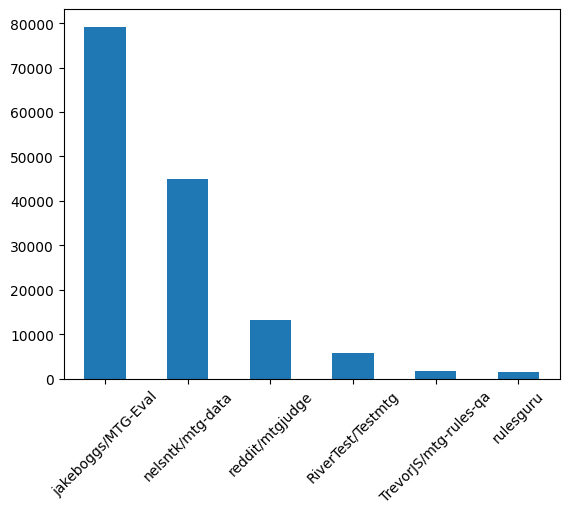

In [2]:
full_ds = pd.concat(all_df, ignore_index=True)[["prompt", "response", "dataset_name"]]
full_ds = full_ds.dropna()
full_ds = full_ds.map(clean_text)
full_ds = full_ds.drop_duplicates(subset=["prompt"])
full_ds["dataset_name"].value_counts().plot.bar(rot=45, xlabel="")

## 2. Embedding & Projection

In [3]:
from sentence_transformers import SentenceTransformer

embedding_model = "mixedbread-ai/mxbai-embed-large-v1"

model = SentenceTransformer(embedding_model)

embeddings = model.encode(
    full_ds["prompt"].tolist(), batch_size=512, show_progress_bar=True
)

full_ds["embeddings"] = [embeddings[i] for i in range(embeddings.shape[0])]

/home/javierj/miniconda3/envs/gatherer-sage/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 286/286 [05:30<00:00,  1.16s/it]


## 3. Plotting

In [4]:
import pacmap

embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)
projections = embedding_projector.fit_transform(embeddings, init="pca")

full_ds["projections"] = [projections[i] for i in range(projections.shape[0])]

/home/javierj/miniconda3/envs/gatherer-sage/lib/python3.10/site-packages/pacmap/pacmap.py:822: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [5]:
from sklearn.cluster import KMeans

num_clusters = 6
classification = KMeans(n_clusters=num_clusters, random_state=0).fit_predict(embeddings)
full_ds["kmeans_classification"] = classification

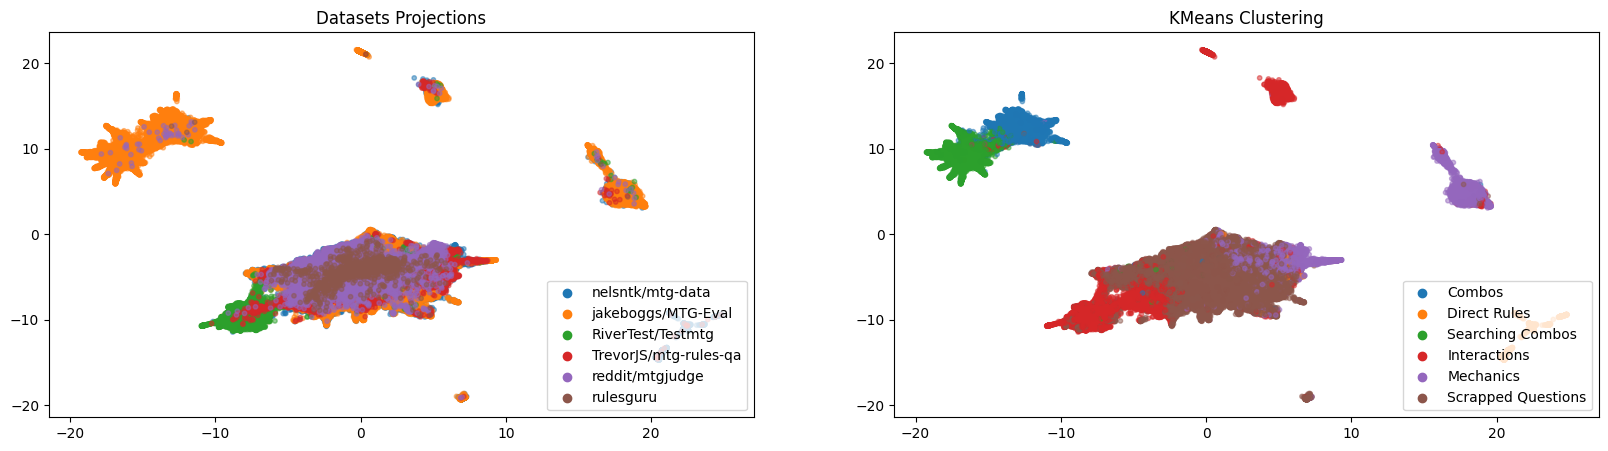

In [6]:
import matplotlib.pyplot as plt

colors = {
    "nelsntk/mtg-data": "tab:blue",
    "jakeboggs/MTG-Eval": "tab:orange",
    "RiverTest/Testmtg": "tab:green",
    "TrevorJS/mtg-rules-qa": "tab:red",
    "reddit/mtgjudge": "tab:purple",
    "rulesguru": "tab:brown",
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.scatter(
    projections[:, 0],
    projections[:, 1],
    alpha=0.5,
    color=[colors[c] for c in full_ds["dataset_name"]],
    s=10,
)

# Create legends
for dataset_name, color in colors.items():
    ax1.scatter([], [], color=color, label=dataset_name)

ax1.legend()
ax1.set_title("Datasets Projections")


kmeans_colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:cyan",
]
ax2.scatter(
    projections[:, 0],
    projections[:, 1],
    alpha=0.5,
    color=[kmeans_colors[c] for c in full_ds["kmeans_classification"]],
    s=10,
)
ax2.set_title("KMeans Clustering")

kmeans_titles = [
    "Combos",
    "Direct Rules",
    "Searching Combos",
    "Interactions",
    "Mechanics",
    "Scrapped Questions",
]

# Create legends
for i, title in enumerate(kmeans_titles):
    ax2.scatter([], [], color=kmeans_colors[i], label=title)

ax2.legend()

plt.show()

## 4. Analysis

In [7]:
for i in range(num_clusters):
    print(f"=== CLUSTER {i} ===")
    display(full_ds[full_ds["kmeans_classification"] == i].sample(10)["prompt"])

=== CLUSTER 0 ===


65244     What combo can be performed with Kiki-Jiki, Mi...
56176     What combo can be performed with Ghostly Flicker?
87679     What happens when you combine Selvala, Heart o...
97231     Which card can you exchange your life total wi...
120929    What combo can you perform with Anje Falkenrat...
94984     What combo can be performed with the card Lena...
109653    What combo can be performed with the card Biov...
60491     What combo can you perform with Lotus Cobra, R...
48676     Which card would you need to have in order to ...
119970    Which Magic card can be part of a combo involv...
Name: prompt, dtype: object

=== CLUSTER 1 ===


2716                           What is rule 702.131b?
656                              What is rule 100.1b?
1651                             What is rule 601.2h?
906                              What is rule 113.3c?
2886                             What is rule 704.6c?
2803                           What is rule 702.156a?
1396                             What is rule 313.2.?
1182                             What is rule 203.1.?
3109                             What is rule 719.8.?
29704    What is a ruling regarding Thieving Amalgam?
Name: prompt, dtype: object

=== CLUSTER 2 ===


72471     What combo can you perform with Feasting Troll...
86212     Which card can create infinite ETB, LTB, landf...
75446     What combo can be performed with Ghostly Flick...
119097    Which card can generate infinite +1/+1 counter...
59527     Which combo involves the card Famished Paladin...
64006     What card can be used to create an infinite co...
57247     Which combo can be performed with the card Spa...
83122     What combo can you perform with Rootha, Mercur...
111593    Which card can be combined with Squee, the Imm...
69522     Which Magic card, when paired with Phyrexian A...
Name: prompt, dtype: object

=== CLUSTER 3 ===


47255        Explain what the card Pride of the Clouds does
115443    How many cards can you discard when resolving ...
160196    "playing" a card rulings for circu interacting...
128075                 Explain the Stax Effects tag in MTG.
127797    prompt would generate this response: MTG has s...
64250     How do you play the revealed card when using t...
65055             How does the card Phyrexian Negator work?
120172                   Is the exiled card exiled face up?
103054         What does the card Underworld Rage-Hound do?
112000                  Describe the card Infiltration Lens
Name: prompt, dtype: object

=== CLUSTER 4 ===


106002                     please describe display of power
6                                  What is Activation Cost?
63768     What portions of Buyback costs does Memory Cry...
145726    What is the activation cost for the transmute ...
106984                   please describe thrashing mudspawn
21049     What types of permanents can be targeted by Fe...
112053                        how does veilborn ghoul work?
142969    What determines the order in which effects are...
9137      What happens when you cast Evangelize and choo...
47697                  Please describe Patron of the Orochi
Name: prompt, dtype: object

=== CLUSTER 5 ===


10357     What is the order of resolution for Electrosta...
5089      What happens if an outside person chooses a cr...
11272     What happens if there are no other creatures o...
109537    What happens when you activate Steel Overseer'...
13338     What happens if multiple players choose to sac...
53922     When resolving the triggered ability of Stampe...
5469      What's the clarification on whether Zombie Ogr...
32215     Strionic resonator copying dragon mage or mind...
100820    What happens if some, but not all, of the targ...
115746    When does Majestic Myriarch's second ability t...
Name: prompt, dtype: object

## 5. Storing

In [8]:
train_df = full_ds[full_ds["dataset_name"] != "rulesguru"][["prompt", "response"]]
train_df.to_csv("../data/huge_corpus/train.csv", index=False)

test_df = full_ds[full_ds["dataset_name"] == "rulesguru"][["prompt", "response"]]
test_df.to_csv("../data/huge_corpus/test.csv", index=False)